# TESSplot

This set of code will show you how to:

1. Obtain TESS data products from the MAST archive using the `astroquery` package
2. Extract the information needed to make plots from the TESS data
3. Plot a TESS lightcurve
4. Phase-fold the TESS lightcurve to examine transits

Let's start with importing the necessary modules, and making sure the text on all our plots is big enough.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
import numpy as np
import astroquery
from astroquery.mast import Catalogs
from astroquery.mast import Observations
import urllib
import os
import sys
matplotlib.rcParams.update({'font.size': 14})

Okay, now let's download some TESS data!

We'll use the `astroquery` module for this - it's a nice way to look at what's available, and download a lightcurve file.

Let's try it for a known exoplanet, WASP-132 b. Its TIC (TESS Input Catalog) ID is **TIC 12862099**.

In [74]:
from astroquery.mast import Observations

tic_id = ["127530399"]

obs = Observations.query_criteria(obs_collection = 'TESS', target_name = tic_id, dataproduct_type = "timeseries")

product = obs[0]["dataURL"]
print(product)

result = Observations.download_file(product)
print(result)

mast:TESS/product/tess2019112060037-s0011-0000000127530399-0143-s_lc.fits
INFO: Found cached file C:\Users\faith\Documents\PhD\WPy64-3850\notebooks\WAKE\TESSplot\Session\tess2019112060037-s0011-0000000127530399-0143-s_lc.fits with expected size 1984320. [astroquery.query]
('COMPLETE', None, None)


Let's call the file and see what information it has in the header and columns.

In [76]:
fits_file = 'tess2019112060037-s0011-0000000127530399-0143-s_lc.fits'

fits.info(fits_file)
fits.getdata(fits_file, ext=1).columns

Filename: tess2019112060037-s0011-0000000127530399-0143-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   19527R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

The things we need for plotting are:

1. **TIME** - this is in units of BJD-2457000 days (this is just a TESS constant)
2. **SAP_FLUX** - this is the un-detrended flux
3. **PDCSAP_FLUX** - this is the detrended flux
4. **PDCSAP_FLUX_ERR** - the error on the detrended flux
5. **SAP_BKG** - this is the background flux, which can be useful for seeing if an event is an asteroid rather than a real transit event (asteroids will show a peak in the background flux, transits won't)

In [77]:
with fits.open(fits_file, mode="readonly") as hdulist:
    time = hdulist[1].data['TIME']
    sap = hdulist[1].data['SAP_FLUX']
    flux = hdulist[1].data['PDCSAP_FLUX']
    bkg = hdulist[1].data['SAP_BKG']

Now we can start plotting! Let's first take a look at the un-detrended SAP flux.

Text(0, 0.5, 'SAP flux [e-/s]')

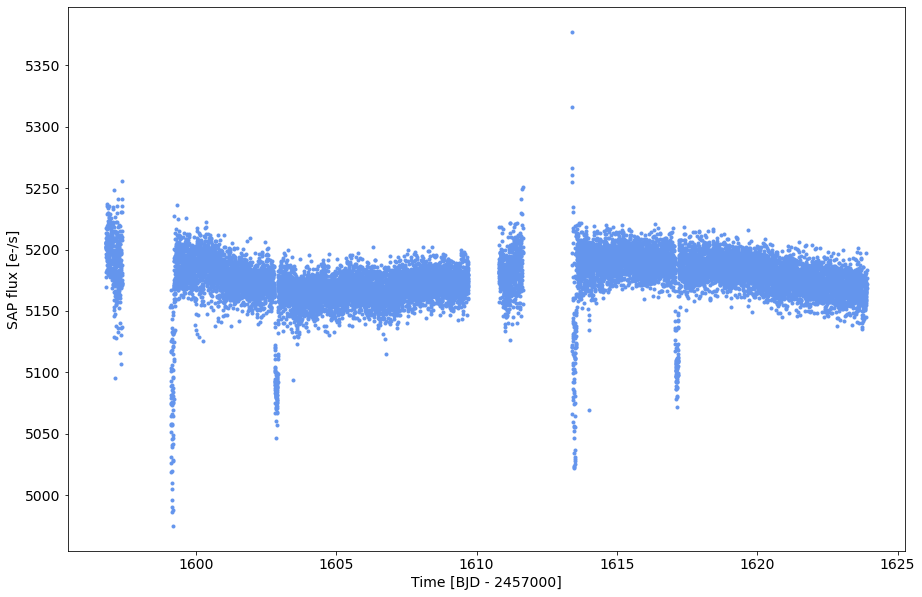

In [78]:
fig = plt.figure(figsize = (15, 10))

plt.plot(time, sap, '#6495ed', marker='.', linestyle='None')
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('SAP flux [e-/s]')

Looks a bit messy, right? Luckily, we have our detrended flux, which should remove some of the nastiness...

Text(0, 0.5, 'PDCSAP flux [e-/s]')

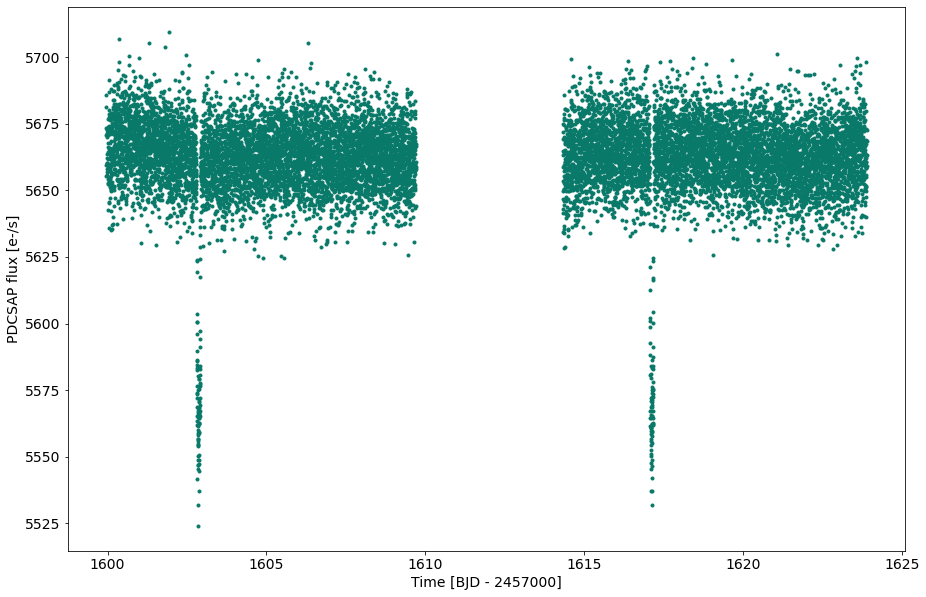

In [79]:
fig = plt.figure(figsize = (15, 10))

plt.plot(time, flux, '#097969', marker='.', linestyle='None')
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('PDCSAP flux [e-/s]')

Wow, that looks much better! We can even see some transits now.

In order to look at the transit events a bit closer, we're going to phase-fold them. This is essentially like 'copy-pasting' transits on top of each other, and looking at them in units of phase rather than time. Let's go ahead and calculate the phase for each datapoint.

For this, we'll need to know the epoch of the first transit (ie. the timestamp where the first transit happens), and the period of the planet. We can get these values from the ExoFOP archive - see if you can find the values!

In [80]:
epoch = 2456698.2076 - 2457000

period = 7.133521

Okay, now to calculate the phase - don't worry if it gives an error.

In [81]:
phase = (((time-(epoch + (0.5*period))) % period)/period)-0.5

<ipython-input-81-fca07a7b0baf>:1: RuntimeWarning: invalid value encountered in remainder
  phase = (((time-(epoch + (0.5*period))) % period)/period)-0.5


Okay, let's have a look at the phase-fold!

Text(0, 0.5, 'PDCSAP flux [e-/s]')

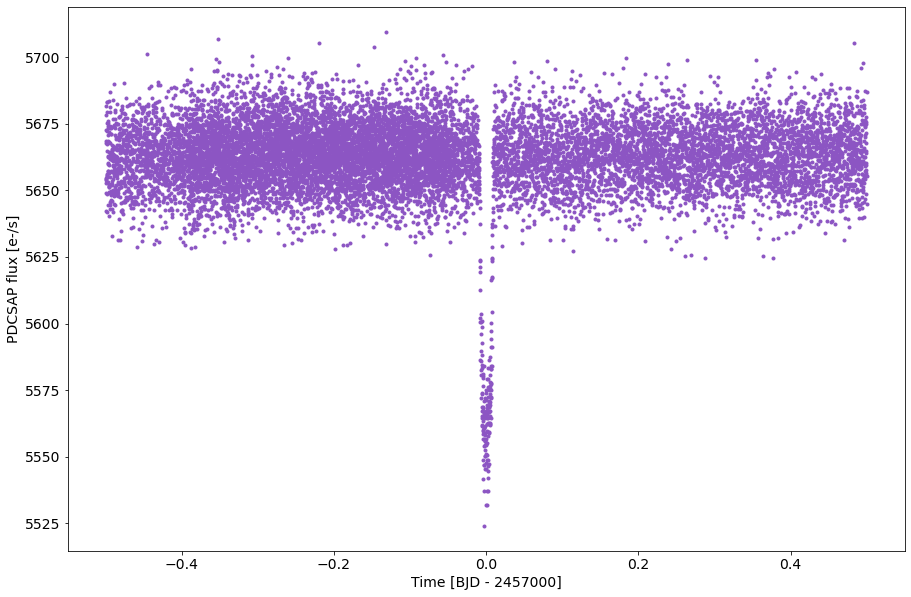

In [86]:
fig = plt.figure(figsize = (15, 10))

plt.plot(phase, flux, '#8C55C3', marker='.', linestyle='None')
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('PDCSAP flux [e-/s]')

Now we can also zoom in on the lightcurve by restricting our x-axis range.

(-0.05, 0.05)

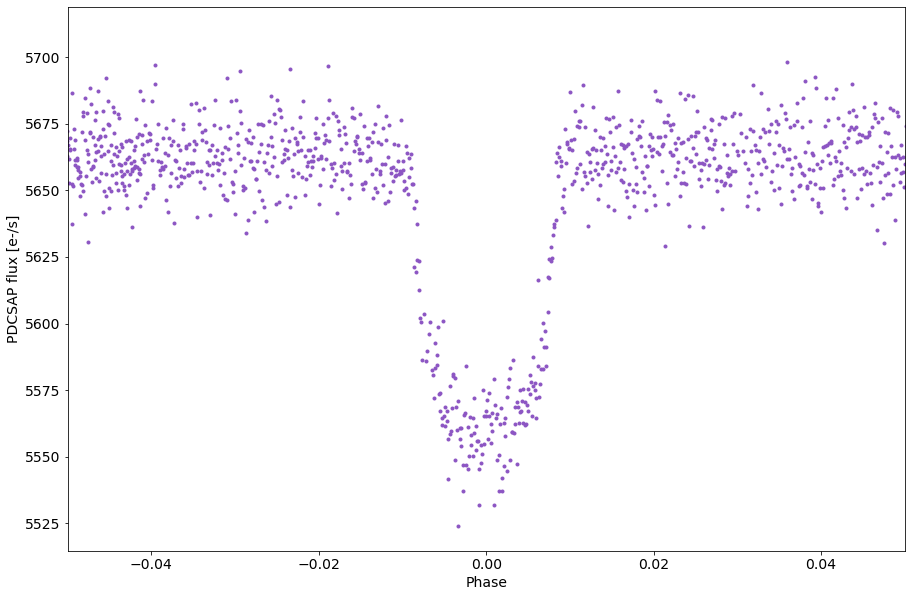

In [88]:
fig = plt.figure(figsize = (15, 10))

plt.plot(phase, flux, '#8C55C3', marker='.', linestyle='None')
plt.xlabel('Phase')
plt.ylabel('PDCSAP flux [e-/s]')
plt.xlim(-0.05,0.05)